# Finding a Circuit

In [1]:
import sys 
sys.path.append("/home/daniel/ml_workspace/circuit-finder")

In [2]:
from circuit_finder.pretrained import load_model
model = load_model()

/home/daniel/ml_workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
male_profession = "doctor"
female_profession = "nurse"

clean_text = f"The {male_profession} is ready, you can go see"
answer = " him"
wrong_answer = " her"
corrupt_text = f"The {female_profession} is ready, you can go see"


In [5]:
# Tokenize
clean_tokens = model.to_tokens(clean_text)
answer_tokens = model.to_tokens(answer, prepend_bos=False).squeeze(-1)
wrong_answer_tokens = model.to_tokens(wrong_answer, prepend_bos=False).squeeze(-1)
corrupt_tokens = model.to_tokens(corrupt_text)

print(clean_tokens.shape)
print(answer_tokens.shape)
print(corrupt_tokens.shape)

torch.Size([1, 10])
torch.Size([1])
torch.Size([1, 10])


In [6]:
from transformer_lens import utils 

utils.test_prompt(clean_text, answer, model)
utils.test_prompt(corrupt_text, wrong_answer, model)

Tokenized prompt: ['<|endoftext|>', 'The', ' doctor', ' is', ' ready', ',', ' you', ' can', ' go', ' see']
Tokenized answer: [' him']


Performance on answer token:
Rank: 0        Logit: 15.83 Prob: 36.58% Token: | him|

Top 0th token. Logit: 15.83 Prob: 36.58% Token: | him|
Top 1th token. Logit: 15.08 Prob: 17.31% Token: | her|
Top 2th token. Logit: 14.11 Prob:  6.60% Token: | the|
Top 3th token. Logit: 13.83 Prob:  4.96% Token: | your|
Top 4th token. Logit: 13.48 Prob:  3.48% Token: | it|
Top 5th token. Logit: 13.13 Prob:  2.46% Token: | if|
Top 6th token. Logit: 13.04 Prob:  2.26% Token: |.|
Top 7th token. Logit: 12.87 Prob:  1.91% Token: | a|
Top 8th token. Logit: 12.80 Prob:  1.77% Token: | his|
Top 9th token. Logit: 12.58 Prob:  1.43% Token: | what|


Ranks of the answer tokens: [(' him', 0)]

Tokenized prompt: ['<|endoftext|>', 'The', ' nurse', ' is', ' ready', ',', ' you', ' can', ' go', ' see']
Tokenized answer: [' her']


Performance on answer token:
Rank: 0        Logit: 16.20 Prob: 50.15% Token: | her|

Top 0th token. Logit: 16.20 Prob: 50.15% Token: | her|
Top 1th token. Logit: 14.17 Prob:  6.61% Token: | the|
Top 2th token. Logit: 13.78 Prob:  4.47% Token: | if|
Top 3th token. Logit: 13.55 Prob:  3.57% Token: | it|
Top 4th token. Logit: 13.40 Prob:  3.07% Token: | what|
Top 5th token. Logit: 13.28 Prob:  2.71% Token: | your|
Top 6th token. Logit: 13.15 Prob:  2.39% Token: | him|
Top 7th token. Logit: 13.13 Prob:  2.33% Token: |.|
Top 8th token. Logit: 12.95 Prob:  1.95% Token: | for|
Top 9th token. Logit: 12.63 Prob:  1.42% Token: | a|


Ranks of the answer tokens: [(' her', 0)]

In [7]:
from circuit_finder.utils import clear_memory

if 'leap' in globals():
    del leap
clear_memory()

In [8]:
import torch
from eindex import eindex
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.patching.ablate import get_metric_with_ablation
from circuit_finder.patching.indirect_leap import IndirectLEAP, LEAPConfig
from circuit_finder.utils import clear_memory

ablate_tokens = corrupt_tokens

def compute_logit_diff(model, clean_tokens, answer_tokens, wrong_answer_tokens):
    clean_logits = model(clean_tokens)
    last_logits = clean_logits[:, -1, :]
    correct_logits = eindex(last_logits, answer_tokens, "batch [batch]")
    wrong_logits = eindex(last_logits, wrong_answer_tokens, "batch [batch]")
    return correct_logits - wrong_logits

def metric_fn(model, tokens):
    logit_diff = compute_logit_diff(model, tokens, answer_tokens, wrong_answer_tokens)
    return logit_diff.mean()

# NOTE: First, get the ceiling of the patching metric.
# TODO: Replace 'last_token_logit' with logit difference
with torch.no_grad():
    ceiling = metric_fn(model, clean_tokens).item()
print(ceiling)

# NOTE: Second, get floor of patching metric using empty graph, i.e. ablate everything
with torch.no_grad():
    empty_graph = EAPGraph([])
    floor = get_metric_with_ablation(
        model,
        empty_graph,
        clean_tokens,
        metric_fn,
        hooked_mlp_transcoder_dict,
        attn_sae_dict,
        ablate_nodes="bm",
        ablate_errors=False,  # Do not ablate errors when running forward pass
        first_ablated_layer=2,
        corrupt_tokens = ablate_tokens,
    ).item()
clear_memory()
print(floor)


# now sweep over thresholds to get graphs with variety of numbers of nodes
# for each graph we calculate faithfulness
num_nodes_list = []
metrics_list = []

# Sweep over thresholds
# TODO: make configurable
# thresholds = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.0]
thresholds = [0.001]
for threshold in thresholds:
    # Setup LEAP algorithm
    model.reset_hooks()
    cfg = LEAPConfig(threshold=threshold,
                    contrast_pairs=True, 
                    qk_enabled=True,
                    chained_attribs=True,
                    abs_attribs = False,
                    store_error_attribs=True)
    leap = IndirectLEAP(
        cfg=cfg,
        tokens=clean_tokens,
        model=model,
        metric=metric_fn,
        attn_saes=attn_saes,  # type: ignore
        transcoders=transcoders,
        corrupt_tokens=ablate_tokens,
    )

    # Populate the graph
    leap.run()

    # Save the graph
    graph = EAPGraph(leap.graph)
    error_graph = EAPGraph(leap.error_graph)
    num_nodes = len(graph.get_src_nodes())

    # # Calculate the metric under ablation
    with torch.no_grad():
        metric = get_metric_with_ablation(
            model,
            graph,
            clean_tokens,
            metric_fn,
            hooked_mlp_transcoder_dict,
            attn_sae_dict,
            ablate_nodes="bm",
            ablate_errors=False,
            first_ablated_layer=2,
            corrupt_tokens = ablate_tokens,
        ).item()
    clear_memory()
    print(metric)

0.7484092712402344
-2.2224950790405273
-1.7874259948730469


In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
from circuit_finder.plotting import make_html_graph

# print(len(graph.get_edges()))
make_html_graph(leap)


['<|endoftext|>', 'The', ' doctor', ' is', ' ready', ',', ' you', ' can', ' go', ' see'] ['<|endoftext|>', 'The', ' nurse', ' is', ' ready', ',', ' you', ' can', ' go', ' see']
graph.html
Generated graph.html. Open this file in Live Server to view the graph.


In [11]:
if 'leap' in globals():
    del leap
clear_memory()

In [12]:
# Convert the graph to a dataframe

import pandas as pd 
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info, edge_type in graph.graph:
    (dest, src) = edge
    if dest == "null": continue
    (node_node_attr, node_node_grad, edge_metric_attr, edge_metric_grad) = edge_info

    src_module_name, src_layer, src_token_idx, src_feature_idx = parse_node_name(src)    
    dest_module_name, dest_layer, dest_token_idx, dest_feature_idx = parse_node_name(dest)

    rows.append({
        "src_module_name": src_module_name,
        "src_layer": src_layer,
        "src_token_idx": src_token_idx,
        "src_feature_idx": src_feature_idx,
        "dest_module_name": dest_module_name,
        "dest_layer": dest_layer,
        "dest_token_idx": dest_token_idx,
        "dest_feature_idx": dest_feature_idx,
        "edge_metric_attr": edge_metric_attr,
        "edge_metric_grad": edge_metric_grad,
        "node_node_attr": node_node_attr,
        "node_node_grad": node_node_grad,
        "edge_type": edge_type
    }) 

df = pd.DataFrame(rows)
print(len(df))
df.head()

345


,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type
0,mlp,0,9,4863,metric,12,9,0,0.021989,0.003526,0.021989,0.003526,None
1,mlp,0,9,11891,metric,12,9,0,0.009094,0.002660,0.009094,0.002660,None
2,mlp,0,9,20543,metric,12,9,0,0.022519,0.001831,0.022519,0.001831,None
3,mlp,0,9,23862,metric,12,9,0,0.025424,0.004463,0.025424,0.004463,None
4,mlp,1,9,9645,metric,12,9,0,-0.009077,0.002790,-0.009077,0.002790,None


## Node Attribution 



In [13]:
import torch

from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders
from circuit_finder.patching.gradient_cache import get_gradient_cache

with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    grad_cache = get_gradient_cache(spliced_model, clean_tokens, metric_fn)

    with torch.no_grad():
        _, clean_cache = model.run_with_cache(clean_tokens)
        _, corrupt_cache = model.run_with_cache(corrupt_tokens)


In [14]:
# Compute node attributions
attr_cache = {}
for node, grad in grad_cache.items():
    # NOTE on sign: 
    # clean - corr --> positive attrib means metric(clean) is higher than metric(corr). 
    attr_cache[node] = grad * (clean_cache[node] - corrupt_cache[node])

In [15]:
# Get the features with high attribution 

import pandas as pd

attn_act_names = [
    f"blocks.{layer}.attn.hook_z.hook_sae_acts_post" for layer in range(model.cfg.n_layers)
]

transcoder_act_names = [
    f"blocks.{layer}.mlp.transcoder.hook_sae_acts_post" for layer in range(model.cfg.n_layers)
]

all_act_names = attn_act_names + transcoder_act_names


def get_node_attrib_df():
    dfs = []
    for act_name in all_act_names:
        node_attrib = attr_cache[act_name]
        feature_idx = list(range(node_attrib.shape[-1]))
        total_node_attrib = node_attrib.sum(0).sum(0).tolist()
        
        df = pd.DataFrame({
            "feature_idx": feature_idx,
            "total_node_attrib": total_node_attrib,
        })
        df['act_name'] = act_name
        df['layer'] = int(act_name.split('.')[1])
        df['module_name'] = act_name.split('.')[2]
        dfs.append(df)

    df = pd.concat(dfs)
    print(len(df))
    df.head()

node_attrib_df = get_node_attrib_df()


589824


# Micro Analysis

In [16]:
def get_outgoing_edge_df(
    df: pd.DataFrame, 
    src_module_name: str,
    src_layer: int,
    src_feature_idx: int,
):
    return df[
        (df["src_module_name"] == src_module_name)
        & (df["src_layer"] == src_layer)
        & (df["src_feature_idx"] == src_feature_idx)
    ]

def get_incoming_edge_df(
    df: pd.DataFrame, 
    dest_module_name: str,
    dest_layer: int,
    dest_feature_idx: int,
):
    return df[
        (df["dest_module_name"] == dest_module_name)
        & (df["dest_layer"] == dest_layer)
        & (df["dest_feature_idx"] == dest_feature_idx)
    ]

In [42]:
# Define some utilities for patching a single node

from transformer_lens import ActivationCache
from circuit_finder.core.types import Node, parse_node_name

def get_act_name(module_name, layer):
    if module_name == "attn":
        return f"blocks.{layer}.attn.hook_z.hook_sae_acts_post"
    elif module_name == "mlp":
        return f"blocks.{layer}.mlp.transcoder.hook_sae_acts_post"
    else:
        raise ValueError(module_name)

def get_node_act(
    cache: ActivationCache,
    module_name, layer, token_idx, feature_idx
):
    act_name = get_act_name(module_name, layer)
    return cache[act_name][:, token_idx, feature_idx]

def node_patch_hook(act, hook, token_idx, feature_idx, value):
    """ Patches a node by setting its activation to a fixed value. """
    act[:, token_idx, feature_idx] = value
    return act

def get_node_patch_hook(
    node: Node,
    value: float
):

    module_name, layer, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_act_name(module_name, layer)

    def hook_fn(act, hook):
        return node_patch_hook(act, hook, token_idx, feature_idx, value)
    
    return hook_name, hook_fn


In [17]:
from circuit_finder.core.types import get_node_name, parse_node_name

nodes = {
    "doctor_detector": get_node_name("mlp", 1, 2, 10644),
}

### Doctor Detector

Look at the outgoing edges

In [30]:
module_name, layer, token_idx, feature_idx = parse_node_name(nodes["doctor_detector"])
get_outgoing_edge_df(df, module_name, layer, feature_idx).sort_values('edge_metric_attr', ascending = False)

,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type
234,mlp,1,2,10644,mlp,7,2,22510,0.001120,0.009598,0.067385,0.577717,None
285,mlp,1,2,10644,mlp,6,2,13188,0.000958,0.008213,0.095022,0.814663,None
331,mlp,1,2,10644,mlp,3,2,19883,0.000869,0.007447,0.115886,0.993540,None
243,mlp,1,2,10644,mlp,7,2,7611,0.000847,0.007260,0.042722,0.366278,None
302,mlp,1,2,10644,mlp,5,2,5922,0.000664,0.005693,0.090604,0.776791,None
307,mlp,1,2,10644,mlp,5,2,17446,0.000597,0.005118,0.054334,0.465831,None
281,mlp,1,2,10644,mlp,6,2,15503,0.000467,0.004004,0.061043,0.523348,None
147,mlp,1,2,10644,attn,10,9,19969,0.000423,0.003630,0.004838,0.041476,ov
223,mlp,1,2,10644,attn,8,9,18618,0.000409,0.003509,0.005144,0.044099,ov
220,mlp,1,2,10644,attn,8,9,919,0.000403,0.003452,0.014395,0.123412,ov


Pot 

In [ ]:
# Node patching for L8.Att.14.16513
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    for value in range(11):
        with model.hooks(fwd_hooks = [get_node_patch_hook(l8_att_node, value)]):
            metric = metric_fn(model, clean_tokens).item()
            print(value, metric)

Plot cosine similarity to MLP weights

In [39]:
from einops import repeat
import torch.nn.functional as F

# Get the relevant weights
W_dec = transcoders[1].W_dec
mlp_W_out = model.blocks[1].mlp.W_out
w_dec = W_dec[10644]
w_dec_repeat = repeat(w_dec, 'f -> b f', b = mlp_W_
print(w_dec_repeat.shape)
print(mlp_W_out.shape)
# Compute cosine similarity

cosine_sim = F.cosine_similarity(w_dec, mlp_W_out, dim=-1)
print(cosine_sim.shape)
cosine_sim_np = cosine_sim.detach().cpu().numpy()



torch.Size([3072, 768])
torch.Size([3072, 768])
torch.Size([3072])


Text(0.5, 1.0, 'Cosine similarity between doctor detector W_dec and Layer 1 MLP W_out')

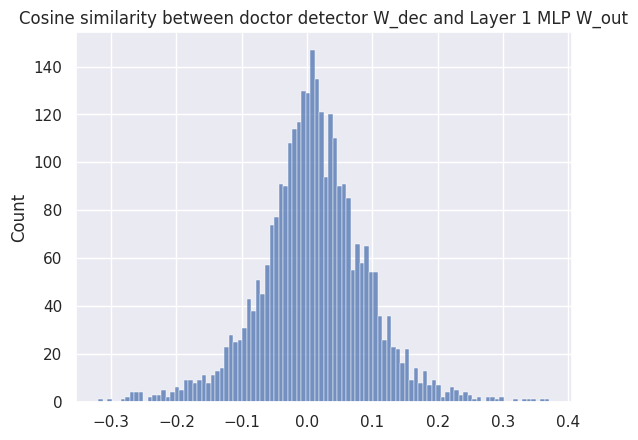

In [41]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set_theme()
sns.histplot(cosine_sim_np, bins=100)
plt.title("Cosine similarity between doctor detector W_dec and Layer 1 MLP W_out")


### "Him" Predictor


# Analysis

In [19]:
# Upstream edges for layer 6 att 17410

get_incoming_edge_df(df, "attn", 6, 17410)

,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type


In [20]:
# Downstream edges for layer 6 att 17410

get_outgoing_edge_df(df, "attn", 6, 17410)

,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type


In [21]:
node_df = df[
    (df["src_layer"] == 8) 
    & (df["src_module_name"] == "attn") 
    & (df["src_feature_idx"] == 16513)
]

node_df

,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type


In [22]:
node_df = df[
    (df["src_layer"] == 10) 
    & (df["src_module_name"] == "attn") 
    & (df["src_feature_idx"] == 3849)
]

node_df

,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type


## Node Ablations

In [23]:
from circuit_finder.core.types import get_node_name

l6_att_node = get_node_name("attn", 6, 10, 17410)
l8_att_node = get_node_name("attn", 8, 14, 16513)
l10_att_node = get_node_name("attn", 10, 14, 3849)

In [24]:
# Get the clean and corrupt cache
from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders

def filter_sae_acts_and_errors(name: str):
    return "hook_sae_acts_post" in name or "hook_sae_error" in name

with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    _, clean_cache = model.run_with_cache(clean_tokens, names_filter = filter_sae_acts_and_errors)
    _, corrupt_cache = model.run_with_cache(corrupt_tokens, names_filter = filter_sae_acts_and_errors)



In [25]:
# Define some utilities for patching a single node

from transformer_lens import ActivationCache
from circuit_finder.core.types import Node, parse_node_name

def get_act_name(module_name, layer):
    if module_name == "attn":
        return f"blocks.{layer}.attn.hook_z.hook_sae_acts_post"
    elif module_name == "mlp":
        return f"blocks.{layer}.mlp.transcoder.hook_sae_acts_post"
    else:
        raise ValueError(module_name)

def get_node_act(
    cache: ActivationCache,
    module_name, layer, token_idx, feature_idx
):
    act_name = get_act_name(module_name, layer)
    return cache[act_name][:, token_idx, feature_idx]

def node_patch_hook(act, hook, token_idx, feature_idx, value):
    """ Patches a node by setting its activation to a fixed value. """
    act[:, token_idx, feature_idx] = value
    return act

def get_node_patch_hook(
    node: Node,
    value: float
):

    module_name, layer, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_act_name(module_name, layer)

    def hook_fn(act, hook):
        return node_patch_hook(act, hook, token_idx, feature_idx, value)
    
    return hook_name, hook_fn

print(get_node_act(clean_cache, "attn", 6, 10, 17410))
print(get_node_act(corrupt_cache, "attn", 6, 10, 17410))

IndexError: index 10 is out of bounds for dimension 1 with size 10

In [ ]:
# Node patching for L6.Att.10.17410
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    for value in range(11):
        with model.hooks(fwd_hooks = [get_node_patch_hook(l6_att_feat, value)]):
            metric = metric_fn(model, clean_tokens).item()
            print(value, metric)

NameError: name 'l6_att_feat' is not defined

In [ ]:
l8_att_node_info = parse_node_name(l8_att_node)
print(get_node_act(clean_cache, *l8_att_node_info))
print(get_node_act(corrupt_cache, *l8_att_node_info))

tensor([9.3522], device='cuda:0')
tensor([0.], device='cuda:0')


In [ ]:
# Node patching for L8.Att.14.16513
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    for value in range(11):
        with model.hooks(fwd_hooks = [get_node_patch_hook(l8_att_node, value)]):
            metric = metric_fn(model, clean_tokens).item()
            print(value, metric)

0 2.6199398040771484
1 2.6861095428466797
2 2.7564697265625
3 2.830913543701172
4 2.9091930389404297
5 2.990968704223633
6 3.0757503509521484
7 3.1629371643066406
8 3.251924514770508
9 3.3420658111572266
10 3.432809829711914


In [ ]:
l10_att_node_info = parse_node_name(l10_att_node)
print(get_node_act(clean_cache, *l10_att_node_info))
print(get_node_act(corrupt_cache, *l10_att_node_info))

tensor([21.6992], device='cuda:0')
tensor([0.], device='cuda:0')


In [ ]:
# Node patching for L10.Att.14.16513
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    for value in range(11):
        with model.hooks(fwd_hooks = [get_node_patch_hook(l10_att_node, value)]):
            metric = metric_fn(model, clean_tokens).item()
            print(value, metric)

0 2.545804977416992
1 2.5825119018554688
2 2.619386672973633
3 2.6564464569091797
4 2.6936283111572266
5 2.730976104736328
6 2.768484115600586
7 2.8061351776123047
8 2.843921661376953
9 2.8818435668945312
10 2.9199295043945312


In [ ]:
# Test prompt
from transformer_lens.utils import test_prompt

with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes) as spliced_model:
    with model.hooks(fwd_hooks = [get_node_patch_hook(l10_att_node, value)]):
        metric = metric_fn(model, clean_tokens).item()
        print(value, metric)
        test_prompt(clean_text, answer, model)

10 2.9199295043945312
Tokenized prompt: ['<|endoftext|>', 'When', ' John', ' and', ' Mary', ' went', ' to', ' the', ' shop', ',', ' John', ' gave', ' a', ' bottle', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 17.84 Prob: 63.98% Token: | Mary|

Top 0th token. Logit: 17.84 Prob: 63.98% Token: | Mary|
Top 1th token. Logit: 15.64 Prob:  7.10% Token: | them|
Top 2th token. Logit: 15.51 Prob:  6.22% Token: | the|
Top 3th token. Logit: 14.92 Prob:  3.46% Token: | his|
Top 4th token. Logit: 14.92 Prob:  3.45% Token: | John|
Top 5th token. Logit: 13.82 Prob:  1.15% Token: | their|
Top 6th token. Logit: 13.76 Prob:  1.08% Token: | her|
Top 7th token. Logit: 13.66 Prob:  0.98% Token: | a|
Top 8th token. Logit: 13.18 Prob:  0.60% Token: | him|
Top 9th token. Logit: 13.06 Prob:  0.54% Token: | Mrs|


Ranks of the answer tokens: [(' Mary', 0)]

In [ ]:
from transformer_lens import ActivationCache
from circuit_finder.core.types import Node, parse_node_name

def get_edge_patch_hook(
    clean_cache: ActivationCache,
    corrupt_cache: ActivationCache,
    src_module, # either HookedSAE or HookedTranscoder
    src_node: Node,
    dest_module, # either HookedSAE or HookedTranscoder
    dest_node: Node,
):
    pass
    


First, let's try ablating one of the important edges and confirm that the metric goes down. 

# Appendi



In [ ]:
# Jacob's code 
def ablation_hook(act, hook, id_to_ablate):
    assert hook.name.endswith("hook_sae_acts_post")
    act[:, :, id_to_ablate] = 0
    return act

def patch_hook(act, hook, module, layer, feature_id, patch_pt, scale):
    if module == "mlp":
        decoder_col = mlp_transcoders[layer].W_dec[feature_id, :]
    elif module == "attn":
        decoder_col_concat = attn_saes[layer].W_dec[feature_id, :]
        decoder_col = rearrange(
            decoder_col_concat, 
            "(n_heads d_head -> n_heads d_head)",
            n_heads=model.cfg.n_heads
            )
    return act + scale*decoder_col